In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pandas.tools.plotting import autocorrelation_plot
import pandas as pd
import itertools
import warnings

In [2]:
# First we read in the sunspot data
fileName = "data/international-airline-passengers.csv"

# Load the data
df = pd.read_csv(fileName, engine='python', skipfooter=3)
# A bit of pre-processing to make it nicer
df['Month']=pd.to_datetime(df['Month'], format='%Y-%m-%d')
df.set_index(['Month'], inplace=True)

In [3]:
df.head()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


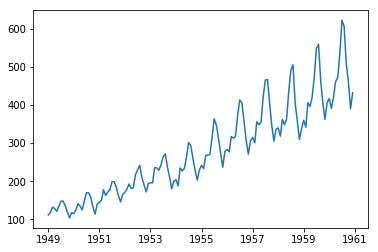

In [4]:
# Plot the full Sunspot data set
plt.plot(df)
plt.show()

In [5]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 3)

t = range(12,24,12)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p, d, q,t))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


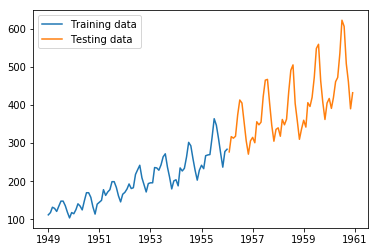

In [6]:
# Now we split our data into training vs testing
train_data = df['1949-01-01':'1956-01-01']
test_data = df['1956-02-01':'1960-12-01']

# Plot the two datasets
plt.clf()
plt.plot(train_data,label="Training data")
plt.plot(test_data,label= "Testing data")
plt.legend()
plt.show()

In [7]:

warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [8]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 358.42736072776376 for model SARIMAX(2, 1, 0)x(2, 1, 1, 12)


In [9]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [10]:
#print(results.get_prediction(dynamic=False).predicted_mean["1770-01-02":"1856-01-02"])

In [11]:
#print(results.get_prediction().predicted_mean["1770-01-02":"1856-01-02"])
#print(results.get_forecast("1960-12-01").predicted_mean)

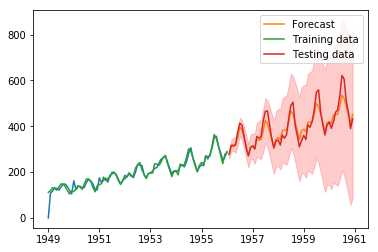

In [12]:

pred  =  results.get_forecast("1960-12-01")
pred_ci = pred.conf_int()
pred_mean = pred.predicted_mean

plt.clf()
plt.plot(results.get_prediction(dynamic=False).predicted_mean['1949-01-01':'1956-01-01'])
plt.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],alpha=0.2, color='r')
plt.plot(pred_mean,label="Forecast")
plt.plot(train_data,label="Training data")
plt.plot(test_data,label="Testing data")
plt.legend()
plt.show()